<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [1]:
%matplotlib inline

# Setup environment and collect initial data

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [3]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [4]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [5]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [6]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

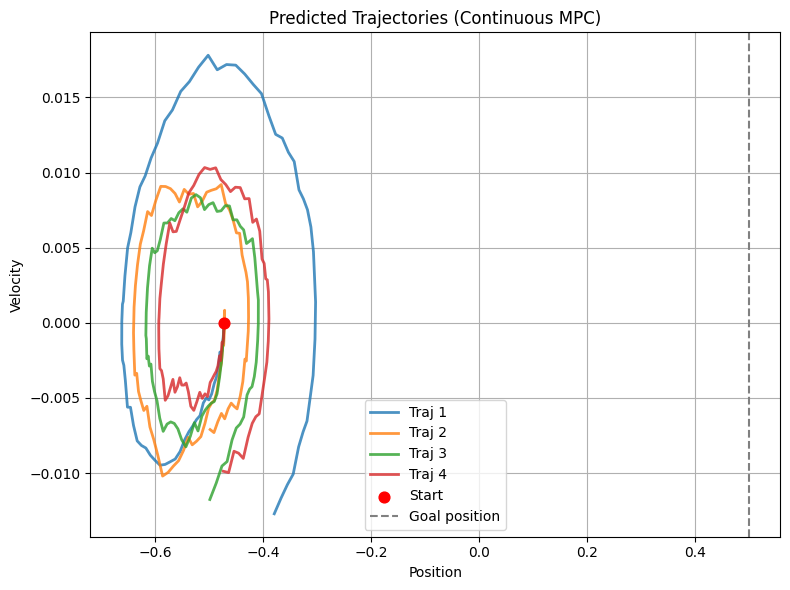

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    U = np.random.uniform(low=-1, high=1, size=(N_seq, H))

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = U[best_idx[0], 0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)

In [10]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.624090774730806


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


t= 10 state= [-0.51730174  0.00543099] a= -0.2666091688086587
t= 20 state= [-0.45271114  0.0075953 ] a= 0.9711352065831091
t= 30 state= [-0.393008    0.00304121] a= -0.24060511863365086
t= 40 state= [-0.42613137 -0.00890159] a= -0.10741829324893915
t= 50 state= [-0.5627057 -0.0160868] a= -0.8363194357076589
t= 60 state= [-0.7357326  -0.01511384] a= 0.8659331386187239
t= 70 state= [-0.77812594  0.00666899] a= 0.09413277520826546
t= 80 state= [-0.5941273   0.02654799] a= 0.7513988779870384
t= 90 state= [-0.28636417  0.03046017] a= 0.8318979082930864
t= 100 state= [-0.055797    0.01237729] a= 0.12291560262309864
t= 110 state= [-0.07020074 -0.01337476] a= 0.741655584496514
t= 120 state= [-0.31661773 -0.03435706] a= 0.1260866561081435
t= 130 state= [-0.72807825 -0.04219076] a= -0.57369317408724
t= 140 state= [-1.0764022  -0.02678795] a= -0.3514588919613486
t= 150 state= [-1.1849597   0.00812532] a= 0.7289990642661108
t= 160 state= [-0.94241124  0.03729199] a= 0.6375897148430816
t= 170 state

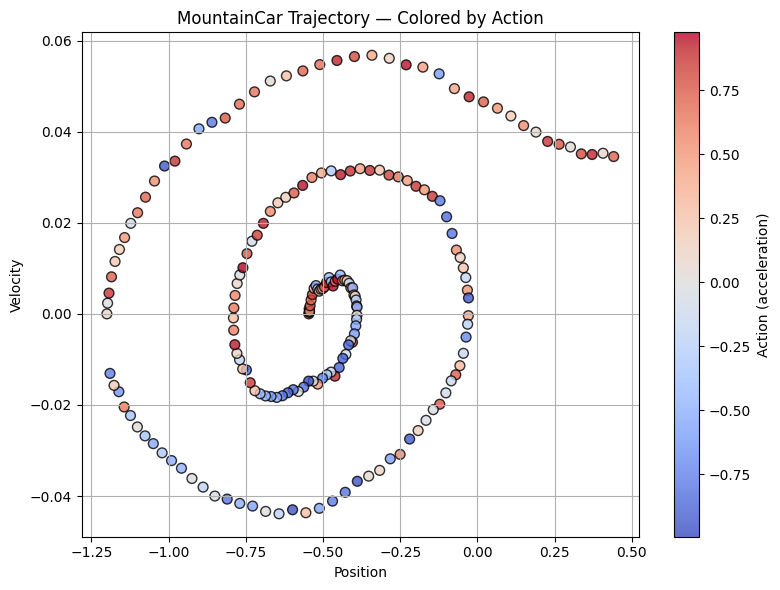

In [11]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

It chooses the best action by generating random action sequences for a future horizon. At each sequence it simulates the trajectory and calculates the total cost along that trajectory using the defined cost function. Increasing the horizon allows the MPC to think about the long-term costs. A larger H's find more optimal behavior's over time. However, increasing H also increases the computational cost. Increasing the number of sampled sequences increases the probability that one of the random sequences is close to the true optimal sequence. A larger N_seq usually leads to better performance but has more computation. The car narrowed in on the goal consistantly.

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

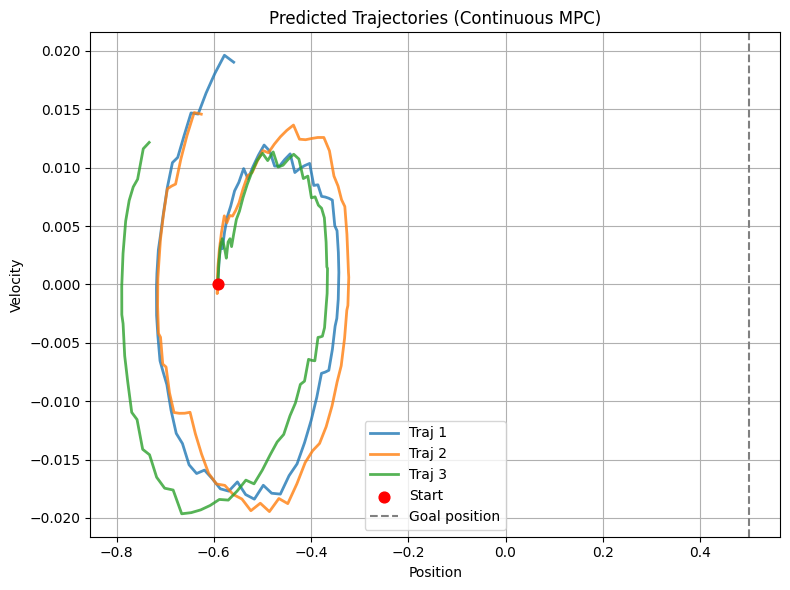

0.10567322890764268


In [16]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0


        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(loc=0, scale=σ, size=(N_seq, H))
        U_sampled = self.U_mean + noise
        U_sampled = np.clip(U_sampled, -1, 1)


        # 2. Roll out trajectories
        all_traj, J = roll_out_n_trajectories(state, U_sampled)


        # 3. Select the best trajectory (lowest cost)
        best_k = np.argmin(J)
        self.U_mean = U_sampled[best_k]


        #  Optional: plot best trajectories
        if plot:
            best_k_plot = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k_plot]
            plot_trajectories(state, best_traj)


        # 4. Return the first action of the best sequence
        best_action = self.U_mean[0]
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)
print(a)

In [13]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.7456826884466573
10 [-0.5541884  -0.01468724] -0.7371147459001038
20 [-0.72714156 -0.01784226] -0.4527946389368537
30 [-0.8116873   0.00340903] 1.0
40 [-0.60667443  0.03292071] 1.0
50 [-0.21264237  0.04047003] 0.9273051483003276
60 [0.1441097  0.03135786] 1.0
70 [0.43524855 0.0294715 ] 1.0
Total time: 70


<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipython-input-1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


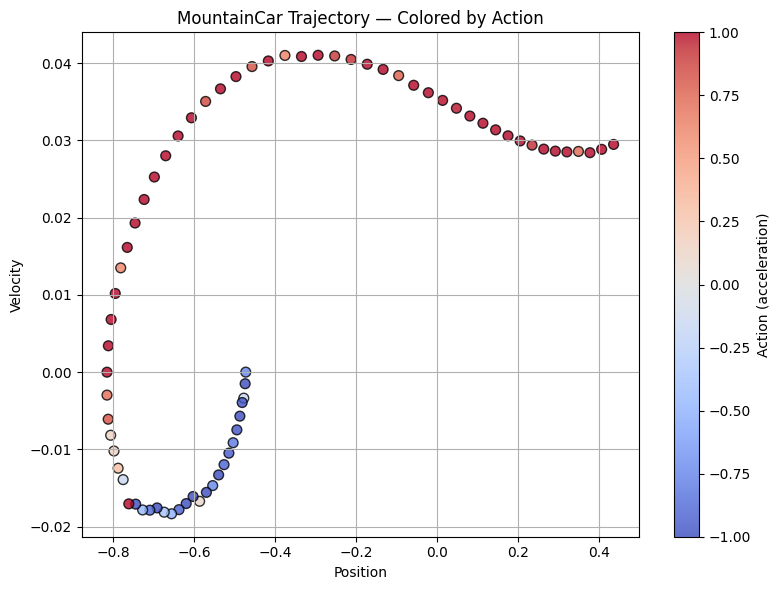

Energy 56.51491906105873


In [17]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

MPPI reuses the previous mean action sequence because the optimal action sequence at the current time step will likely to be close to the optimal action sequence from the previous time step. If we didn't shift the time step at each itereation we would be using old means that don't represent states close to the current one. Longer horizens imporve stability since it can consider future costs and rewards. Smaller horizens coul possibly improve responsiveness since they consider more short term things. Reusing and shifting the mean action sequence with MPPI starts its search in a more relevant region of the action space compared to random shooting. This seams to be smoother because of its use of means as well.

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


In [31]:

def cost_stop_at_goal(state, a):
    x, v = state
    goal = 0.5

    return (goal - x)**2 + abs(v)*75

def cost_fn_save_energy(state, a):
    x, v = state
    goal = 0.5
    return (goal - x)**2 + a**2 * 500


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)


obs, _ = env.reset(seed=0)


def roll_out_trajectory(s0, Ui, gamma=1.0, this_cost_fn=cost_stop_at_goal):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += this_cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U, this_cost_fn):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i],this_cost_fn=this_cost_fn)

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5,this_cost_fn=cost_fn_save_energy):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    U = np.random.uniform(low=-1, high=1, size=(N_seq, H))

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U,cost_fn)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = U[best_idx[0], 0]
    return best_action

def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80
N_seq = 200
steps = 500


obs, _ = env.reset()
returns = 0.0
a = 0.0

trajectory = []

for t in range(steps):

    a = mpc_action(obs, H=H, N_seq=N_seq, this_cost_fn=cost_stop_at_goal)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)


    next_obs, r, term, trunc, _ = env.step([a])
    trajectory.append([obs,a])
    env.render()

    returns += r


    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.959457252684307


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


t= 10 state= [-0.4793154   0.01037156] a= 0.8206021142046092
t= 20 state= [-0.37999365  0.00673361] a= -0.12839691005933274
t= 30 state= [-0.3827407  -0.00698714] a= -0.7121371419582276
t= 40 state= [-0.52340734 -0.02032735] a= -0.057531154104502935
t= 50 state= [-0.7322973  -0.01868623] a= 0.5407789245537511
t= 60 state= [-8.331436e-01 -5.826602e-04] a= -0.49330528529180384
t= 70 state= [-0.74814767  0.01763011] a= 0.41381745617907373
t= 80 state= [-0.46876872  0.03384917] a= 0.6882753538895814
t= 90 state= [-0.15329199  0.02528119] a= -0.85702514815861
t= 100 state= [-0.05038092 -0.001831  ] a= -0.2336752575287362
t= 110 state= [-0.20173635 -0.02511377] a= -0.8598188510561369
t= 120 state= [-0.5866877  -0.04547941] a= -0.07216921832659251
t= 130 state= [-0.9970156  -0.03572654] a= -0.11704219503001423
t= 140 state= [-1.196927    0.00307312] a= 0.3725891568495361
t= 150 state= [-1.0233337   0.03014418] a= -0.06447032128539609
t= 160 state= [-0.5757041   0.05722241] a= -0.1147511191955

Running MPC with other cost funcs
t= 0 state= [-0.47260767  0.        ] a= -0.6602526636342345
t= 50 state= [-6.5978485e-01 -4.2267825e-04] a= 0.4466863366931999
t= 100 state= [-0.49463183 -0.03135791] a= -0.0716172879888699
t= 150 state= [-0.09921455  0.03626817] a= 0.719341123408737
t= 200 state= [-1.1595974  -0.03600227] a= -0.4886010019309488

Episode reward with cost_fn_stop_at_goal: 90.43


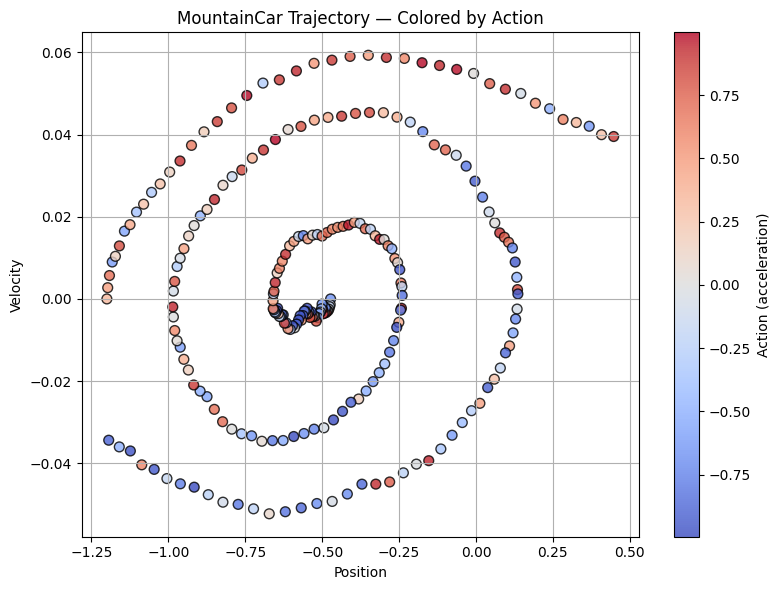

In [42]:
H = 80
N_seq = 200
steps = 500


obs, _ = env.reset(seed=0)
returns_stop_at_goal = 0.0
a = 0.0

trajectory_stop_at_goal = []

print("Running MPC with other cost funcs")
for t in range(steps):

    a = mpc_action(obs, H=H, N_seq=N_seq,this_cost_fn=cost_stop_at_goal)

    if t%50==0:
        print("t=",t, "state=", obs, "a=",a)


    next_obs, r, term, trunc, _ = env.step([a])
    trajectory_stop_at_goal.append([obs,a])

    returns_stop_at_goal += r

    obs = next_obs
    if term or trunc:
        break

print(f"\nEpisode reward with cost_stop_at_goal: {returns_stop_at_goal:.2f}")



plot_trajectory(trajectory_stop_at_goal)

t= 0 state= [-0.47260767  0.        ] a= -0.3966113280086394
t= 50 state= [-0.48897472  0.02015338] a= 0.9578129173485874
t= 100 state= [-0.888345   -0.02910999] a= -0.5518770090750411
t= 150 state= [0.10502286 0.02555791] a= -0.7252061818774957
t= 200 state= [-1.2  0. ] a= -0.8097761722505707

Episode reward with cost_fn_save_energy: 90.63


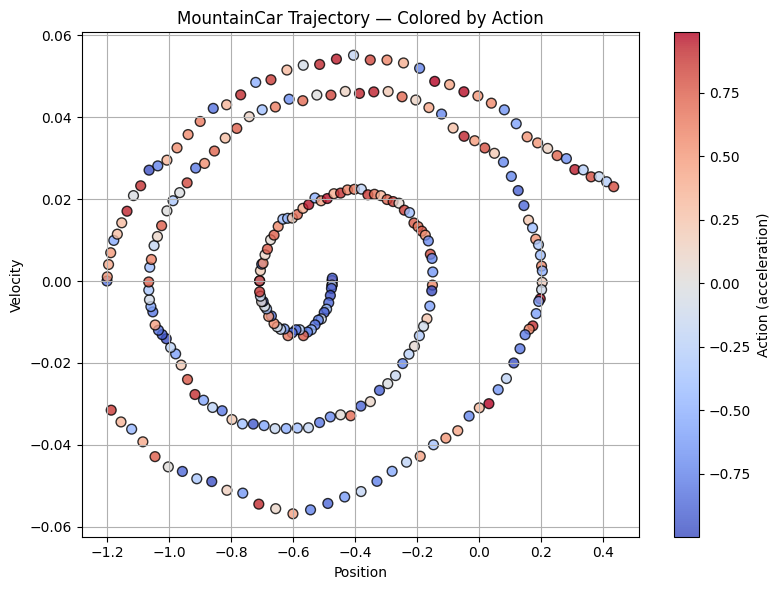

In [43]:
H = 80
N_seq = 200
steps = 500


obs, _ = env.reset(seed=0)
returns_stop_at_goal = 0.0
a = 0.0

trajectory_stop_at_goal = []

for t in range(steps):

    a = mpc_action(obs, H=H, N_seq=N_seq,this_cost_fn=cost_fn_save_energy)

    if t%50==0:
        print("t=",t, "state=", obs, "a=",a)


    next_obs, r, term, trunc, _ = env.step([a])
    trajectory_stop_at_goal.append([obs,a])

    returns_stop_at_goal += r

    obs = next_obs
    if term or trunc:
        break

print(f"\nEpisode reward with cost_fn_save_energy: {returns_stop_at_goal:.2f}")



plot_trajectory(trajectory_stop_at_goal)

I think that maybe the punishments we too much since it is not very stable although did approach 0, just not as quickly as I had hoped. This is true for both of these loss functions.It definately decreased velocity very quickly. Actually I think it was too quickly. The car did pretty much stop at 0 which is good for both of these. Actually this is not quite true for stop at goal. It looks to me like it was still oscillating at a non-negligable level. The terms with the squares were significant for sure but at a smaller scale the coeeficients became more significant in relation to the exponents.

